In [1]:
#Handle Imports
import cv2
import numpy as np
import math
import pylab as pl
import matplotlib.pyplot as plt
import random

from os import listdir
from os.path import isfile, join
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.models import load_model

from __future__ import print_function
from __future__ import division
np.random.seed(1337)  # for reproducibility

%matplotlib inline

Using TensorFlow backend.


In [2]:
import os
for filename in os.listdir("Positives/"):
        if filename.endswith('.jpg'):
            newpath = 'Positives/' + filename 
            img = cv2.imread(newpath ,0)
            rows, cols = img.shape
        for x in range(4):
            if filename.endswith('.jpg'):
                p = os.path.join(os.path.join('Positives/', 'data'), filename  + '_' + str(x * 90) + '.jpg')
                cv2.imwrite(p,img)
                
                #Rotate image
                img = np.rot90(img)

In [3]:
import os
for filename in os.listdir("Negatives/"):
        if filename.endswith('.jpg'):
            newpath = 'Negatives/' + filename 
            img = cv2.imread(newpath ,0)
            rows, cols = img.shape
        for x in range(4):
            if filename.endswith('.jpg'):
                p = os.path.join(os.path.join('Negatives/', 'data'), filename  + '_' + str(x * 90) + '.jpg')
                cv2.imwrite(p,img)
                
                #Rotate image
                img = np.rot90(img)

In [4]:
windowsize = 32

In [5]:
'''
This module will handle pre-processing such as labeling inages as positives and negatives.  If you would like to use
the data from the folders just download them and change the paths.
'''

#Read all images from folder.
pospath = "Positives/data/"
positives = [f for f in listdir(pospath) if isfile(join(pospath, f))]

negpath = "Negatives/data/"
negatives = [f for f in listdir(negpath) if isfile(join(negpath, f))]

#create array to hold all data
numImages = len(positives) + len(negatives)
data = np.zeros((numImages, windowsize**2 + 1))

#choose 80/20 ratio for splitting data because of Pareto principle
split = math.floor(numImages * 0.8)

#load Positives
for i in range(len(positives)):
    path = pospath + positives[i]
    particle = cv2.imread(path)
    particle = cv2.cvtColor(particle, cv2.COLOR_BGR2GRAY)
    
    #resize Image to fit window
    particle = cv2.resize(particle, (windowsize, windowsize),interpolation = cv2.INTER_AREA) 
    
    particle = particle.flatten()
    particle = np.insert(particle, windowsize**2, 1)
    data[i] = particle
    
#load Negatives
for i in range(len(negatives)):
    path = negpath + negatives[i]
    particle = cv2.imread(path)
    particle = cv2.cvtColor(particle, cv2.COLOR_BGR2GRAY)
    
    #resize Image to fit window
    particle = cv2.resize(particle, (windowsize, windowsize),interpolation = cv2.INTER_AREA) 
    
    particle = particle.flatten()
    particle = np.insert(particle, windowsize**2, 0)
    data[len(positives) + i] = particle

#shuffle examples
np.random.shuffle(data)
data = data.astype('float32')
#split data into training and testing sets
X_train = data[int(0):int(split), int(0):int(windowsize**2)]
y_train = data[int(0):int(split), int(windowsize**2)]
X_test = data[int(split):,int(0):int(windowsize**2)]
y_test = data[int(split):, int(windowsize**2)]

#reshape images to be routed to classifier
X_train = np.reshape(X_train, (int(split), windowsize, windowsize))
X_test = np.reshape(X_test, (numImages - int(split), windowsize, windowsize))

In [6]:
'''This module will set up hyper parameters and  normalize the data'''

batch_size = 10
nb_classes = 2
nb_epoch = 5

# input image dimensions
img_rows, img_cols = windowsize, windowsize
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train.astype('int'), nb_classes)
Y_test = np_utils.to_categorical(y_test.astype('int'), nb_classes) 

X_train shape: (588, 32, 32, 1)
588 train samples
148 test samples


In [7]:
if os.path.exists('my_model.h5'):
    model = load_model('my_model.h5')
else:
    #Make model
    '''Model creation and fitting'''

    model = Sequential()

    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                            border_mode='valid',
                            input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
              verbose=1, validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])



/home/seyed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 1..., padding="valid")`
  # This is added back by InteractiveShellApp.init_path()
/home/seyed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  del sys.path[0]
/home/seyed/anaconda3/lib/python3.6/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 588 samples, validate on 148 samples
Epoch 1/5
588/588 [==============================] - 1s - loss: 0.4251 - acc: 0.8129 - val_loss: 0.4054 - val_acc: 0.8311
Epoch 2/5
588/588 [==============================] - 1s - loss: 0.3871 - acc: 0.8180 - val_loss: 0.3284 - val_acc: 0.8311
Epoch 3/5
588/588 [==============================] - 1s - loss: 0.3305 - acc: 0.8520 - val_loss: 0.2385 - val_acc: 0.9189
Epoch 4/5
588/588 [==============================] - 1s - loss: 0.3071 - acc: 0.8486 - val_loss: 0.1564 - val_acc: 0.9324
Epoch 5/5
588/588 [==============================] - 0s - loss: 0.2082 - acc: 0.9082 - val_loss: 0.1554 - val_acc: 0.9189
Test score: 0.155398147332
Test accuracy: 0.918918922141


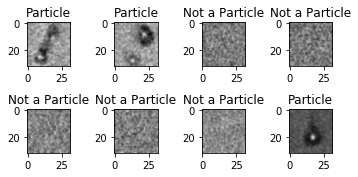

In [8]:
'''Visualize Predictions'''

fig = plt.figure()
fig.subplots_adjust(hspace=1)

predictions = model.predict_classes(X_test, batch_size=32, verbose=0)

displays = 8

for i in range(displays):
    x = random.sample(range(1,len(X_test)), displays)
    img = np.squeeze(X_test[x[i]])
    ax = plt.subplot(341 + i)
    if(predictions[x[i]] == 1):
        ax.set_title("Particle")
    else:
        ax.set_title("Not a Particle")
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')

plt.show()

In [9]:
class classifier:

    def __int__(self, image):
        self.image = image


    def c(self):
        percent = 10
        prob = random.randrange(0,100)
        if prob > percent:
            return False
        else:
            return True

In [10]:
def non_maximum_supression_slow(boxes, overlapThresh):
# if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # initialize the list of picked indexes
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    
        # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]

        # loop over all indexes in the indexes list
        for pos in range(0, last):
            # grab the current index
            j = idxs[pos]

            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])

            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)

            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]

            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > overlapThresh:
                suppress.append(pos)

        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)

    # return only the bounding boxes that were picked
    return boxes[pick]

In [11]:
import time
import random
import pprint
import numpy as np
import sys
import cv2
import os



class SlidingWindow(object):

    def __int__(self, blc, image, classifier, shift_r, shift_d, boundingboxes, gui):

        self.blc = blc
        self.image = image
        self.classifier = classifier
        self.shift_r = shift_r
        self.shift_d = shift_d
        self.boundingboxes = boundingboxes
        self.gui = gui

        """"
        BLC : Bottom Left Corner : This indicates the start point of the sliding window and takes in a value such as 32
        Image : This is the image that will be passed as a numpy array
        Classifier : This is the reference from the CNN handling the identification
        ShiftR : Shift Right : This is how many pixels the image will shift to the right
        ShiftD : Shift Down : This is how many pixels the image will shift down
        """


    def move_slider(self,verbose=0):

        count_x = 0  # number to increase each iteration of while
        count_y = 0
        shape_of_array = np.shape(self.image)  # the dimensions of the numpy Image array

        max_x = shape_of_array[1]  # the dimension along the x axis
        #print( max_x)
        max_y = shape_of_array[0]  # the dimension along the y axis
        #print( max_y)

        slice_obj = (slice(0, self.blc-1, 1), slice(0, self.blc-1, 1))  # sets the slice of 0 to the BLC of each axis
        sub_image = self.image[slice_obj]  # gets the pixel values from the 0 index to the max index of the passed BLC

        blc_x = self.blc
        blc_y = self.blc
        
        count_yes = 1
        dirname = 'Observed'
        

        while blc_y < max_y:

            # first run through starts at 0,0 and has a BLC of what was passed in i.e. 32x32
            # once that has run through this while loop lowers the sub_image(0, ShiftD)

            start_y = count_y * self.shift_d  # where the index of the array should start
            end_y = self.blc - 1 + (count_y * self.shift_d)  # where the index of the array for y should end

            new_y_range = (slice(start_y, end_y, 1))
            # new_y_range is the slice of the y axis from the start of the count to the BLC provided


            while blc_x < max_x:

                # as stated the first run through the top left sets to 0,0
                # in this case the window will slide to the right a number of pixels equal to shift_r

                # first iteration: (0, 0) through (31, 31)
                # second iteration: (shiftR, 0) through (31+ShiftR, 32)

                start_x = count_x * self.shift_r  # where the index of the array should start
                end_x = self.blc - 1 + (count_x * self.shift_r)  # where the index of the array for y should end

                new_x_range = (slice(start_x, end_x, 1))
                # new_x_dim is the slice of the y axis from the start of the count to the BLC provided

                slice_obj = (new_x_range, new_y_range)

                sub_image = self.image[slice_obj]

                shape_of_sub_array = np.shape(sub_image)
                if(sub_image.shape == (windowsize, windowsize) ):
                    myparticle = sub_image.flatten()
                    myparticle = myparticle.reshape(1,  img_rows, img_cols, 1)
                    myparticle = myparticle.astype('float32')
                    myparticle /= 255
                    
                    
                    
                    mypredictions = model.predict_classes(myparticle, batch_size=1, verbose=0)
                    if(mypredictions[0] == 1):
                        if verbose == 1:
                            print('found one at X: ' ,start_x, 'and Y: ' , start_y)
                        
                        
                        file_name = '{}_jar.jpg'.format(count_yes)  # sets the name of each image to a new name inline with count_yes
                        cv2.imwrite(os.path.join(dirname, file_name), sub_image)  # writes the image to a new image with name file_name
                        count_yes += 1  # increments the count change the file name
                        
                       
                        self.boundingboxes.append([start_x,start_y,end_x,end_y])                       
                    
                        
                clone = self.image.copy()
                
                #if verbose == 1:
                    #cv2.imshow("Window", clone)
                    #cv2.waitKey(1)

                count_x += 1
                blc_x = self.blc + (count_x * self.shift_r)

            count_y += 1
            if blc_y < max_y:
                blc_y = self.blc + (count_y * self.shift_d)

            if blc_x >= max_x:
                blc_x = self.blc
                count_x = 0
                
                
        self.boundingboxes = np.array(self.boundingboxes)

In [12]:
import sys
from PyQt5 import QtWidgets,QtGui
import cv2
import numpy as np

class Window(QtWidgets.QWidget):
    
    def __init__(self):
        super(Window,self).__init__()
        
        #self.init_ui()
        
    def init_ui(self):
        
        #Initialize Image
        self.pixmap = QtGui.QPixmap('1.jpg')
        self.image = QtWidgets.QLabel()
        self.image.setPixmap(self.pixmap)
        
        self.setWindowTitle('Particle Detector')
        self.setGeometry(100,100,self.pixmap.width(),self.pixmap.height())
        
        #Initialize Buttons
        self.chooseButton = QtWidgets.QPushButton('Choose Image')
        self.detectButton = QtWidgets.QPushButton('Detect Particles')
        self.segmentButton = QtWidgets.QPushButton('Choose Image')
        self.sizeDistButton = QtWidgets.QPushButton('Size Distribution')
        
        #Set Button Functions
        self.chooseButton.clicked.connect(self.chooseImage)
        self.detectButton.clicked.connect(self.detectParticles)
        self.segmentButton.clicked.connect(self.segmentParticles)
        self.segmentButton.clicked.connect(self.getSizeDist)
        
        #Make Button Panel
        self.buttons = QtWidgets.QHBoxLayout()
        #Add Buttons
        self.buttons.addStretch()
        self.buttons.addWidget(self.chooseButton)
        self.buttons.addStretch()
        self.buttons.addWidget(self.detectButton)
        self.buttons.addStretch()
        self.buttons.addWidget(self.segmentButton)
        self.buttons.addStretch()
        self.buttons.addWidget(self.sizeDistButton)
        self.buttons.addStretch()
        
        #Set Vertical Layout
        self.v_box = QtWidgets.QVBoxLayout()
        self.v_box.addWidget(self.image)
        self.v_box.addLayout(self.buttons)
        
        self.setLayout(self.v_box)
        self.show()
        
    #Choose Image Function
    def chooseImage(self):
        self.options = QtWidgets.QFileDialog.Options()
        self.options |= QtWidgets.QFileDialog.DontUseNativeDialog
        fileName, _ = QtWidgets.QFileDialog.getOpenFileName(self,"QFileDialog.getOpenFileName()", "","All Files (*);;Python Files (*.py)", options=options)
        if fileName:
            print(fileName)
            #Initialize Image
            self.pixmap = QtGui.QPixmap(fileName)
            self.image.setPixmap(self.pixmap)
    
    #Detect Particles Function
    def detectParticles(self):
        return
        
    #Segment Particles Function
    def segmentParticles(self):
        return
    
    #Get Size Distribution Plot Fucntion
    def getSizeDist(self):
        return

In [13]:
def pyramid(above,aboveRatio, below, belowRatio, image, sliding_window):
        stack = None
        
        #Above
        for x in range(1, above+1):
                           
            #Resize Image
            slicefrac = 1+x*belowRatio
            im = cv2.resize(image,None,fx=1/slicefrac, fy=1/slicefrac, interpolation = cv2.INTER_CUBIC)
            sliding_window.image=im
            print("Image Size:", im.shape)
            
            #Run Sliding Window
            sliding_window.boundingboxes = []
            sliding_window.move_slider(verbose=1)
            if stack is None:
                if sliding_window.boundingboxes.shape[0] != 0:
                    #print ("Stack is empty.  But Bounding Boxes shape is: ", sliding_window.boundingboxes.shape[0])
                    stack = sliding_window.boundingboxes
                else:
                    print("Nothing found...")
            else:
                #print ("Stack is not empty.  Stack shape is: ", stack.shape)
                if sliding_window.boundingboxes.shape[0] != 0:
                    #print ("Bounding Boxes shape is: ", sliding_window.boundingboxes.shape[0])
                    sliding_window.boundingboxes = sliding_window.boundingboxes
                    stack = np.concatenate((stack, (sliding_window.boundingboxes*(slicefrac))), axis=0)
                    
            
            
            
        #Middle
        #Set Image
        sliding_window.image=image
        print("Image size: ", image.shape)
        
        #Run Sliding Window
        sliding_window.boundingboxes = []
        sliding_window.move_slider(verbose=1)
        
        if stack is None:
            if sliding_window.boundingboxes.shape[0] != 0:
                #print ("Stack is empty.  But Bounding Boxes shape is: ", sliding_window.boundingboxes.shape[0])
                stack = sliding_window.boundingboxes
            else:
                    print("Nothing found...")
        else:
            #print ("Stack is not empty.  Stack shape is: ", stack.shape)
            #print ("Bounding Boxes shape is: ", sliding_window.boundingboxes.shape)
            if sliding_window.boundingboxes.shape[0] != 0:
                
                stack = np.concatenate((stack, sliding_window.boundingboxes), axis=0)
                #print ("Stack is not empty.  Stack shape is: ", stack.shape)
        
        #Below
        for x in range(1, below+1):
            if stack is None:
                continue
                #print ("Stack is empty")
                
            #Resize Image    
            slicefrac = 1+x*belowRatio
            im = cv2.resize(image,None,fx=slicefrac, fy=slicefrac, interpolation = cv2.INTER_CUBIC)
            sliding_window.image=im
            print("Image size: ", im.shape)
            
            #Run Sliding Window
            sliding_window.boundingboxes = []
            sliding_window.move_slider(verbose=1)
            if stack is None:
                if sliding_window.boundingboxes.shape[0] != 0:
                    #print ("Stack is empty.  But Bounding Boxes shape is: ", sliding_window.boundingboxes.shape[0])
                    stack = sliding_window.boundingboxes
                else:
                        print("Nothing found...")
            else:
                #print ("Stack is not empty.  Stack shape is: ", stack.shape)
                if sliding_window.boundingboxes.shape[0] != 0:
                    stack = np.concatenate((stack, (sliding_window.boundingboxes*(1/slicefrac))), axis=0)
            
        
        return stack

In [14]:
s_w = SlidingWindow()
blc = windowsize + 1
s_w.blc=blc
shift_r = 10
shift_d = 10
s_w.shift_r=shift_r
s_w.shift_d=shift_d
app = 0
app = QtWidgets.QApplication(sys.argv)
yes = Window()
s_w.gui = yes

im = cv2.imread('testIm/test1-5.jpg', 0)

py = pyramid(2, .5, 2, .5, im, s_w)

Image Size: (640, 853)
found one at X:  230 and Y:  470
Image Size: (480, 640)
Image size:  (960, 1280)
found one at X:  310 and Y:  560
found one at X:  310 and Y:  570
found one at X:  350 and Y:  710
found one at X:  350 and Y:  720
found one at X:  360 and Y:  720
Image size:  (1440, 1920)
found one at X:  470 and Y:  850
found one at X:  480 and Y:  850
found one at X:  460 and Y:  860
found one at X:  470 and Y:  860
found one at X:  480 and Y:  860
found one at X:  540 and Y:  1070
found one at X:  530 and Y:  1080
found one at X:  540 and Y:  1080
found one at X:  550 and Y:  1080
found one at X:  520 and Y:  1090
found one at X:  530 and Y:  1090
found one at X:  540 and Y:  1090
found one at X:  550 and Y:  1090
found one at X:  530 and Y:  1100
found one at X:  540 and Y:  1100
Image size:  (1920, 2560)
found one at X:  620 and Y:  1140
found one at X:  630 and Y:  1140
found one at X:  640 and Y:  1140
found one at X:  650 and Y:  1140
found one at X:  620 and Y:  1150
foun

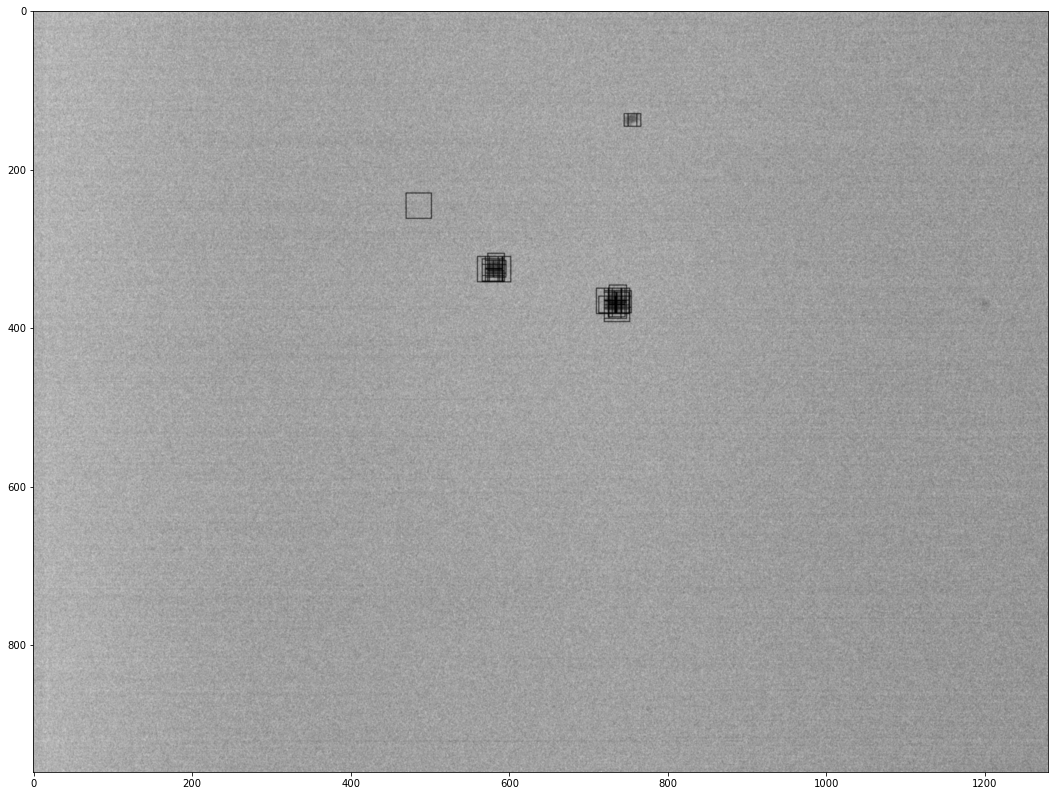

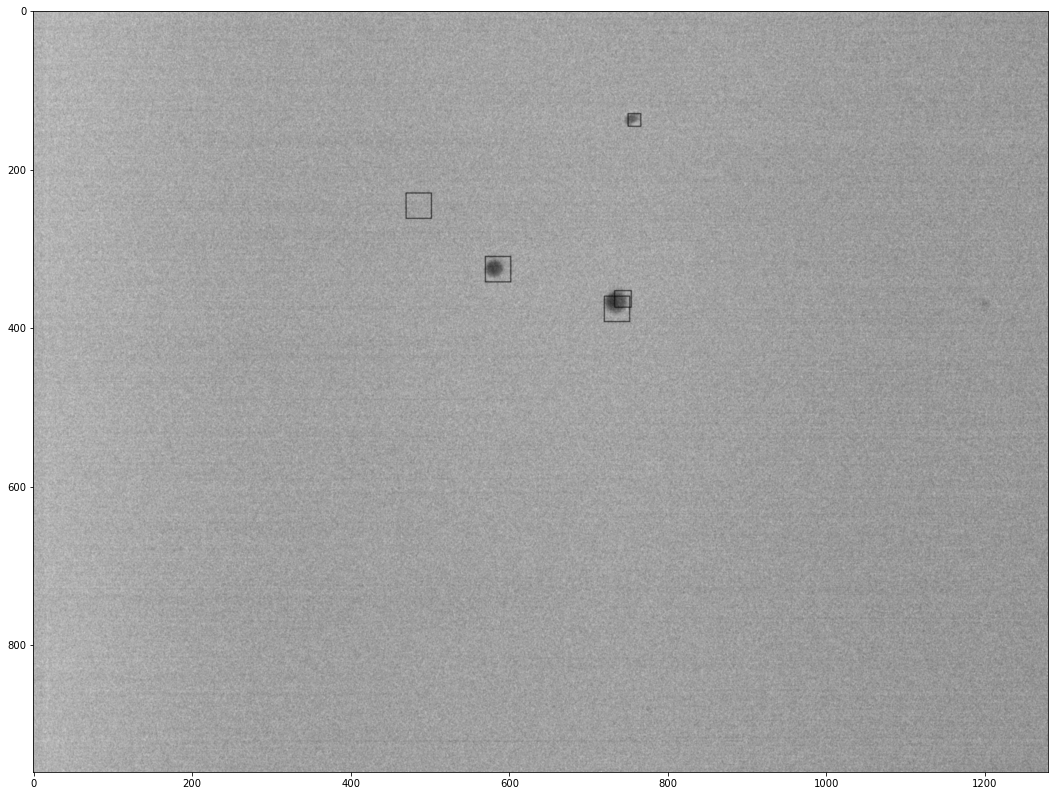

In [15]:
py = py.astype(int)
pre_suppress = np.copy(im)
for y in py:
    cv2.rectangle(pre_suppress, (y[1], y[0]), (y[3], y[2]), (0, 255, 0), 1)
plt.figure(figsize=(26,14))
plt.imshow(pre_suppress,cmap = 'gray', interpolation = 'bicubic')
pick = non_maximum_supression_slow(py, 0.4)
post_suppress = np.copy(im)
for y in pick:
    cv2.rectangle(post_suppress, (y[1], y[0]), (y[3], y[2]), (0, 255, 0), 1)
plt.figure(figsize=(26,14))
plt.imshow(post_suppress,cmap = 'gray', interpolation = 'bicubic')

In [16]:
dirname = "Detected Particles"
if not os.path.isdir(dirname):
    os.makedirs(dirname)
for x in range(pick.shape[0]):
    file_name = '{}_{}.jpg'.format(pick[x,1], pick[x,2])
    img = cv2.resize(im[pick[x,0]:pick[x,2], pick[x,1]:pick[x,3]], (32, 32))
    cv2.imwrite(os.path.join(dirname, file_name), img)  # writes the image to a new image with name file_name

In [18]:
from IPython.display import display, HTML

In [19]:
display(HTML('<h1>Segmentation!</h1>'))

In [20]:
## Imports

In [28]:
import os
print(os.environ['PATH'])  # make sure the path is in the Particle-Detector directory

from scipy import ndimage as ndi

import matplotlib.pyplot as plt
from matplotlib.spines import Spine
from matplotlib.path import Path

from skimage.morphology import watershed, disk
from skimage.filters import rank
from skimage.util import img_as_ubyte

import numpy as np

import cv2



anaconda3/bin:/home/seyed/anaconda2/bin:/home/seyed/anaconda3/bin:/home/seyed/bin:/home/seyed/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin


In [22]:
display(HTML('<h1>Outline the particles !</h1>'))

In [23]:
Base_address = ""# "/home/seyed/Documents/COMP 496ML/"

In [24]:
display(HTML('<h1>getting the right folders</h1>'))

In [29]:
Observed_path = "Observed/"
Post_Processing_path = "Post_Processing/"
Segmented_Particle_path = "Segmented_Particle/"

Observed_dir = os.path.dirname(Base_address + Observed_path)
Post_Processing_dir = os.path.dirname(Base_address + Post_Processing_path)
Segmented_Particle_dir = os.path.dirname(Base_address + Segmented_Particle_path)

if not os.path.exists(Observed_dir):
    os.makedirs(Observed_dir)
    print("Making Observed file.")
    
if not os.path.exists(Post_Processing_dir):
    os.makedirs(Post_Processing_dir)
    print("Making Post_Processing file.")
    
if not os.path.exists(Segmented_Particle_dir):
    os.makedirs(Segmented_Particle_dir)
    print("Making Segmented_Particle file.")
    

In [31]:
display(HTML('<h1>Read images to be processed from the Observed file</h1>'))

In [35]:
## pull from Observed file
direc = Base_address + Observed_path

Observed = [f for f in os.listdir(direc) if os.path.isfile(os.path.join(direc, f))]

data = []
name_set = []

#load Positives
for Observe in Observed:
    path = direc + Observe
    #print(path)
    
    file_name = Observe
    replace = file_name.replace('.','_')
    array_offsets = replace.split('_')
    
    x_offset = int(array_offsets[0])
    y_offset = int(array_offsets[1])
    
    name_set.append([x_offset, y_offset])
    
    particle = cv2.imread(path )
    particle = cv2.cvtColor(particle, cv2.COLOR_BGR2GRAY)
    
    data.append(particle)

In [36]:
display(HTML('<h1>Modify files in Observed to a Threshhold using the Otsu algorithm</h1>'))

In [37]:
gradient_data = []
np.set_printoptions(threshold=5)

for d in data:
    
    img = np.array(d)
    #blur = cv2.bilateralFilter(img,9,75,75)
    blur = cv2.GaussianBlur(img,(5,5),0)
    #blur = cv2.blur(img, (5,5))
    ret, thres = cv2.threshold(blur,0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    print(thres)
    
    gradient_data.append(thres)

[[255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 ..., 
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]]
[[255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 ..., 
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]]
[[255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 ..., 
 [  0   0   0 ..., 255 255 255]
 [  0   0   0 ..., 255 255 255]
 [  0   0   0 ..., 255 255 255]]
[[255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 ..., 
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]]


In [38]:
display(HTML('<h1>Chanvese processing !</h1>'))

In [39]:
def showim(imgpassed):
    
    cv2.imshow('image', imgpassed)
    k = cv2.waitKey(0)
    if k == 27:         # wait for ESC key to exit
        cv2.destroyAllWindows()
    elif k == ord('s'): # wait for 's' key to save and exit
        cv2.imwrite('particle',img)
        cv2.destroyAllWindows()
    

iteration: 0
iteration: 50
iteration: 100
iteration: 150

/home/seyed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:263: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.



iteration: 200
iteration: 250
iteration: 300
iteration: 350
iteration: 400
iteration: 450
iteration: 500
iteration: 550
iteration: 600
iteration: 650
iteration: 700
iteration: 750
iteration: 800
iteration: 850
iteration: 900
iteration: 950
saving file
iteration: 0
iteration: 50
iteration: 100
iteration: 150
iteration: 200
iteration: 250
iteration: 300
iteration: 350
iteration: 400
iteration: 450
iteration: 500
iteration: 550
iteration: 600
iteration: 650
iteration: 700
iteration: 750
iteration: 800
iteration: 850
iteration: 900
iteration: 950
saving file
iteration: 0
iteration: 50
iteration: 100
iteration: 150
iteration: 200
iteration: 250
iteration: 300
iteration: 350
iteration: 400
iteration: 450
iteration: 500
iteration: 550
iteration: 600
iteration: 650
iteration: 700
iteration: 750
iteration: 800
iteration: 850
iteration: 900
iteration: 950
saving file
iteration: 0
iteration: 50
iteration: 100
iteration: 150
iteration: 200
iteration: 250
iteration: 300
iteration: 350
iteration: 4

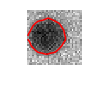

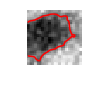

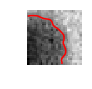

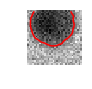

In [42]:
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt

count = 0
circled_data = []
eps = np.finfo(float).eps
max_its = 1000
figure_size = 32

phi_set = []


def chanvese(I, original_I, init_mask, max_its=200, alpha=0.2,
             thresh=0, color='r', display=False):
    I = I.astype(np.float)

    # Create a signed distance map (SDF) from mask
    phi = mask2phi(init_mask)

    if display:
        plt.ion()
        fig = plt.figure(figsize=(1,1))
        ax = fig.add_subplot(111)
        ax.seton=False
        
        #fig, axes = plt.subplots(ncols=1)
        show_curve_and_phi(fig, I, original_I, phi, color)
        plt.savefig('levelset_start.png', bbox_inches='tight')

    # Main loop
    its = 0
    stop = False
    prev_mask = init_mask
    c = 0

    while (its < max_its and not stop):
        # Get the curve's narrow band
        idx = np.flatnonzero(np.logical_and(phi <= 1.2, phi >= -1.2))

        if len(idx) > 0:
            # Intermediate output
            if display:
                if np.mod(its, 50) == 0:
                    print('iteration: {0}'.format(its))
                    show_curve_and_phi(fig, I, original_I, phi, color)
            else:
                if np.mod(its, 10) == 0:
                    print('iteration: {0}'.format(its))

            # Find interior and exterior mean
            upts = np.flatnonzero(phi <= 0)  # interior points
            vpts = np.flatnonzero(phi > 0)  # exterior points
            u = np.sum(I.flat[upts]) / (len(upts) + eps)  # interior mean
            v = np.sum(I.flat[vpts]) / (len(vpts) + eps)  # exterior mean

            # Force from image information
            F = (I.flat[idx] - u)**2 - (I.flat[idx] - v)**2
            # Force from curvature penalty
            curvature = get_curvature(phi, idx)

            # Gradient descent to minimize energy
            dphidt = F / np.max(np.abs(F)) + alpha * curvature

            # Maintain the CFL condition
            dt = 0.45 / (np.max(np.abs(dphidt)) + eps)

            # Evolve the curve
            phi.flat[idx] += dt * dphidt

            # Keep SDF smooth
            phi = sussman(phi, 0.5)

            new_mask = phi <= 0
            c = convergence(prev_mask, new_mask, thresh, c)

            if c <= 5:
                its = its + 1
                prev_mask = new_mask
            else:
                stop = True

        else:
            break

    # Final output
    if display:
        
        print('saving file')
        ####### saving to file 'segmented particle' with the 
        global count 
        Segmented_path = Base_address + 'Post_Processing/'
        Observed_name = name_set[count]
        x_start = Observed_name[0]
        y_start = Observed_name[1]
        filename = Segmented_path + '{}_{}.jpg'.format(x_start, y_start)
        count = count + 1
        
        plt.savefig(filename, bbox_inches='tight',pad_inches = 0, dpi=64)
            
        show_curve_and_phi(fig, I, original_I, phi, color)
        
        
        
        #plt.savefig('levelset_end.png', bbox_inches='tight')

    # Make mask from SDF
    seg = phi <= 0  # Get mask from levelset

    return seg, phi, its


# ---------------------------------------------------------------------
# ---------------------- AUXILIARY FUNCTIONS --------------------------
# ---------------------------------------------------------------------

def bwdist(a):
    """
    Intermediary function. 'a' has only True/False vals,
    so we convert them into 0/1 values - in reverse.
    True is 0, False is 1, distance_transform_edt wants it that way.
    """
    return nd.distance_transform_edt(a == 0)


# Displays the image with curve superimposed
def show_curve_and_phi(fig, I, original_I, phi, color):
    
    #fig.tight_layout(pad=0)
    

    for spine in plt.gca().spines.values():
        spine.set_visible(False)
        
    fig.axes[0].cla()
    fig.axes[0].set_axis_off()
    fig.axes[0].imshow(original_I, cmap='gray')
    fig.axes[0].contour(phi, 0, colors=color)
    
    plt.draw()
    
    
    # Now we can save it to a numpy array.
    #data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    #data = data.reshape((fig.canvas.get_width_height()[::-1] + (3,)))
    
    #circled_data.append(data)
    
    
    
    plt.pause(0.001)


def im2double(a):
    a = a.astype(np.float)
    a /= np.abs(a).max()
    return a


# Converts a mask to a SDF
def mask2phi(init_a):
    phi = bwdist(init_a) - bwdist(1 - init_a) + im2double(init_a) - 0.5
    return phi


# Compute curvature along SDF
def get_curvature(phi, idx):
    dimy, dimx = phi.shape
    yx = np.array([np.unravel_index(i, phi.shape) for i in idx])  # subscripts
    y = yx[:, 0]
    x = yx[:, 1]

    # Get subscripts of neighbors
    ym1 = y - 1
    xm1 = x - 1
    yp1 = y + 1
    xp1 = x + 1

    # Bounds checking
    ym1[ym1 < 0] = 0
    xm1[xm1 < 0] = 0
    yp1[yp1 >= dimy] = dimy - 1
    xp1[xp1 >= dimx] = dimx - 1

    # Get indexes for 8 neighbors
    idup = np.ravel_multi_index((yp1, x), phi.shape)
    iddn = np.ravel_multi_index((ym1, x), phi.shape)
    idlt = np.ravel_multi_index((y, xm1), phi.shape)
    idrt = np.ravel_multi_index((y, xp1), phi.shape)
    idul = np.ravel_multi_index((yp1, xm1), phi.shape)
    idur = np.ravel_multi_index((yp1, xp1), phi.shape)
    iddl = np.ravel_multi_index((ym1, xm1), phi.shape)
    iddr = np.ravel_multi_index((ym1, xp1), phi.shape)

    # Get central derivatives of SDF at x,y
    phi_x = -phi.flat[idlt] + phi.flat[idrt]
    phi_y = -phi.flat[iddn] + phi.flat[idup]
    phi_xx = phi.flat[idlt] - 2 * phi.flat[idx] + phi.flat[idrt]
    phi_yy = phi.flat[iddn] - 2 * phi.flat[idx] + phi.flat[idup]
    phi_xy = 0.25 * (- phi.flat[iddl] - phi.flat[idur] +
                     phi.flat[iddr] + phi.flat[idul])
    phi_x2 = phi_x**2
    phi_y2 = phi_y**2

    # Compute curvature (Kappa)
    curvature = ((phi_x2 * phi_yy + phi_y2 * phi_xx - 2 * phi_x * phi_y * phi_xy) /
                 (phi_x2 + phi_y2 + eps) ** 1.5) * (phi_x2 + phi_y2) ** 0.5

    return curvature


# Level set re-initialization by the sussman method
def sussman(D, dt):
    # forward/backward differences
    a = D - np.roll(D, 1, axis=1)
    b = np.roll(D, -1, axis=1) - D
    c = D - np.roll(D, -1, axis=0)
    d = np.roll(D, 1, axis=0) - D

    a_p = np.clip(a, 0, np.inf)
    a_n = np.clip(a, -np.inf, 0)
    b_p = np.clip(b, 0, np.inf)
    b_n = np.clip(b, -np.inf, 0)
    c_p = np.clip(c, 0, np.inf)
    c_n = np.clip(c, -np.inf, 0)
    d_p = np.clip(d, 0, np.inf)
    d_n = np.clip(d, -np.inf, 0)

    a_p[a < 0] = 0
    a_n[a > 0] = 0
    b_p[b < 0] = 0
    b_n[b > 0] = 0
    c_p[c < 0] = 0
    c_n[c > 0] = 0
    d_p[d < 0] = 0
    d_n[d > 0] = 0

    dD = np.zeros_like(D)
    D_neg_ind = np.flatnonzero(D < 0)
    D_pos_ind = np.flatnonzero(D > 0)

    dD.flat[D_pos_ind] = np.sqrt(
        np.max(np.concatenate(
            ([a_p.flat[D_pos_ind]**2], [b_n.flat[D_pos_ind]**2])), axis=0) +
        np.max(np.concatenate(
            ([c_p.flat[D_pos_ind]**2], [d_n.flat[D_pos_ind]**2])), axis=0)) - 1
    dD.flat[D_neg_ind] = np.sqrt(
        np.max(np.concatenate(
            ([a_n.flat[D_neg_ind]**2], [b_p.flat[D_neg_ind]**2])), axis=0) +
        np.max(np.concatenate(
            ([c_n.flat[D_neg_ind]**2], [d_p.flat[D_neg_ind]**2])), axis=0)) - 1

    D = D - dt * sussman_sign(D) * dD
    return D


def sussman_sign(D):
    return D / np.sqrt(D**2 + 1)


# Convergence Test
def convergence(p_mask, n_mask, thresh, c):
    diff = p_mask - n_mask
    n_diff = np.sum(np.abs(diff))
    if n_diff < thresh:
        c = c + 1
    else:
        c = 0
    return c


if __name__ == "__main__":
    #img = nd.imread('gradient_1.jpg', flatten=True)
    
    for index in range(len(Observed)):
            
        original_image = data[index]
        gradient_image = gradient_data[index]
        
        mask = np.zeros(gradient_image.shape)
        mask[20:100, 20:100] = 1
        

        chanvese(gradient_image, original_image, mask, max_its=1000, display=True, alpha=1.0)
        
        
    

In [43]:
display(HTML('<h1>Read images from the Post_Processing folder</h1>'))

In [44]:
segmented_data = []

Segmentedpath = Base_address + "Post_Processing/"

Segmented = [f for f in os.listdir(Segmentedpath) if os.path.isfile(os.path.join(Segmentedpath, f))]

for Segment in Segmented:
    
    path = Segmentedpath + Segment
    particle = cv2.imread(path)
    segmented_data.append(particle)
    
    

In [45]:
display(HTML('<h1>Cut the white bounding boxes from mathplotlibs output</h1>'))

In [46]:
counttop = 3
countright = 3
countleft = 17
countbottom = 15

toresize = []

for segmented in segmented_data:
    
    
    arr = segmented
    
    for i in range(counttop):
        arr = np.delete(arr, (0), axis=0 )    
        
    for i in range(countright):
        arr = np.delete(arr, (arr.shape[1]-1), axis=1 )
    
    for i in range(countleft):
        arr = np.delete(arr, (0), axis=1 )
        
    for i in range(countbottom):
        arr = np.arr = np.delete(arr, (arr.shape[0]-1), axis=0 )

    
    toresize.append(arr)


In [47]:
display(HTML('<h1>Resize file to 32, 32</h1>'))

In [50]:
segmented = []

for resize in toresize:
    
    im = resize
    resize = cv2.resize(im, (32,32))
    
    segmented.append(resize)


In [51]:
display(HTML('<h1>Save file to "Segmented_Particle"</h1>'))

In [52]:
countin = 0

for i in range(len(segmented)):
    Segmented_particle = Base_address + 'Segmented_Particle/'
    x_start = name_set[i][0]
    y_start = name_set[i][1]
    
    output_file_name = '{}_{}.jpg'.format(x_start, y_start)
    output_full_path = Segmented_particle + output_file_name
    
    cv2.imwrite(output_full_path, segmented[i])

In [53]:
display(HTML('<h1>Contour extraction"</h1>'))

In [55]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [56]:
display(HTML('<h1>Helper functions"</h1>'))

In [57]:
def showim(imgpassed):
    
    cv2.imshow('image', imgpassed)
    k = cv2.waitKey(0)
    if k == 27:         # wait for ESC key to exit
        cv2.destroyAllWindows()
    elif k == ord('s'): # wait for 's' key to save and exit
        cv2.imwrite('particle',img)
        cv2.destroyAllWindows()
    

In [58]:
display(HTML('<h1>checking the proper directories"</h1>'))

In [59]:
Base_address = ""
Segmented_Particle_path = "Segmented_Particle/"
Segmented_Particle_Rectangle_path = "Segmented_Particle_Rectangle/"

In [60]:
Segmented_Particle_Rectangle_dir = os.path.dirname(Base_address + Segmented_Particle_Rectangle_path)

if not os.path.exists(Segmented_Particle_Rectangle_dir):
    os.makedirs(Segmented_Particle_Rectangle_dir)
    print("Making Segmented_Particle_Rectangle file.")
    

In [61]:
display(HTML('<h1>Loading from directory</h1>'))

In [62]:
direc = Base_address + Segmented_Particle_path

Segmented = [f for f in os.listdir(direc) if os.path.isfile(os.path.join(direc, f))]

data = []
name_set = []

#load Positives
for Segment in Segmented:
    path = direc + Segment
    
    particle = cv2.imread(path, 1)
    
    
    file_name = Segment
    replace = file_name.replace('.','_')
    array_offsets = replace.split('_')
    
    x_offset = int(array_offsets[0])
    y_offset = int(array_offsets[1])
    
    name_set.append([x_offset, y_offset])
    data.append(particle)
    

In [63]:
display(HTML('<h1>Mask boundaries"</h1>'))

In [64]:
lower = np.array([0, 15, 100])
upper = np.array([255, 80, 255])

In [65]:
display(HTML('<h1>Calculating the size distribution for the segmented particles</h1>'))

In [66]:
size_dist = []
images = []

for d in data:

    image = d

    mask = cv2.inRange(image, lower, upper)
    output = cv2.bitwise_and(image, image, mask=mask)
    width, height = output.shape[:2]

    img = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(img,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    im2, contours, hierarchy = cv2.findContours(th3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


    largest_area = 0

    for contour in contours:

        cnt = contour
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h

        if (area > largest_area):

            largest_area = area
            index_of_largest_area = contour
            largest_cnt = cnt

        #cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

    rect = cv2.minAreaRect(largest_cnt)
    box = cv2.boxPoints(rect)
    p1, p2, p3, p4 = np.int0(box)
    
    # start shoelace calculation
    area = ((p1[0]*p2[1] - p2[0]*p1[1]) + (p2[0]*p3[1] - p3[0]*p2[1]) + (p3[0]*p4[1] - p4[0]*p3[1]) + (p4[0]*p1[1] - p1[0]*p4[1]))/2
    box = np.int0(box)

    cv2.drawContours(image,[box],0,(0,255,0),1)
    #showim(image)
    
    images.append(image)

    size_dist.append(area)

In [67]:
display(HTML('<h1>Generating the distribution Dataframe & plots</h1>'))

In [68]:
df = pd.DataFrame(size_dist, columns=['Area'])

In [69]:
df.iplot(kind='hist', xTitle='Size of Particle', yTitle='Frequency of Size')

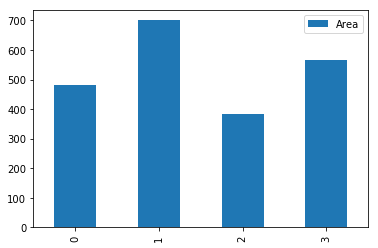

In [70]:
df.plot.bar()

In [71]:
df.iplot(kind='hist', xTitle='Size of Particle', yTitle='Frequency of Size')

In [72]:
display(HTML('<h1>Saving files to "Segmented_Particle_rectangle" folder</h1>'))

In [73]:
for i in range(len(size_dist)):
    Segmented_particle = Base_address + 'Segmented_Particle_Rectangle/'
    x_start = name_set[i][0]
    y_start = name_set[i][1]
    
    output_file_name = '{}_{}_size.jpg'.format(x_start, y_start)
    output_full_path = Segmented_particle + output_file_name
    
    cv2.imwrite(output_full_path, images[i])